<a href="https://colab.research.google.com/github/mkri/master/blob/master/smart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://course19.fast.ai/setup/colab | bash

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [27]:
key = os.environ.get('AZURE_SEARCH_KEY', '0f9faf6d33b74f0092f5670f1c9d2e7c')

In [ ]:
!pip install bing-image-downloader
from bing_image_downloader import downloader

In [ ]:
results = search_images_bing(key, 'drupes fruits')
images = results.attrgot('content_url')
len(images)

In [ ]:
downloader.download("Apple", limit=150, output_dir='fruits', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("Grape", limit=150, output_dir='fruits', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("Pear", limit=150, output_dir='fruits', adult_filter_off=True, force_replace=False, timeout=5)

In [103]:
fruit_types=['Apple', 'Grape', 'Pear']
path = Path('fruits')

In [ ]:
files = get_image_files(path)
files

In [ ]:
corrupt = verify_images(files)
corrupt

In [106]:
fruits = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=41),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [107]:
dls = fruits.dataloaders(path)

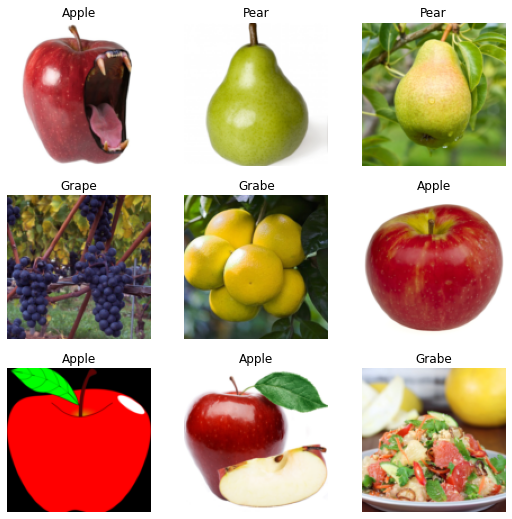

In [108]:
dls.valid.show_batch()

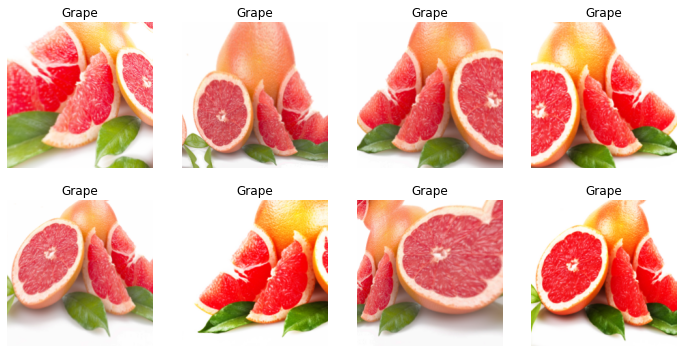

In [109]:
fruit = fruits.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
model = cnn_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(4)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


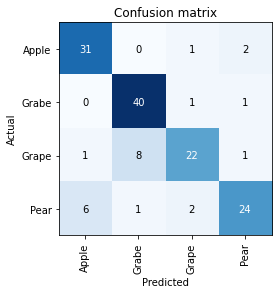

In [113]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

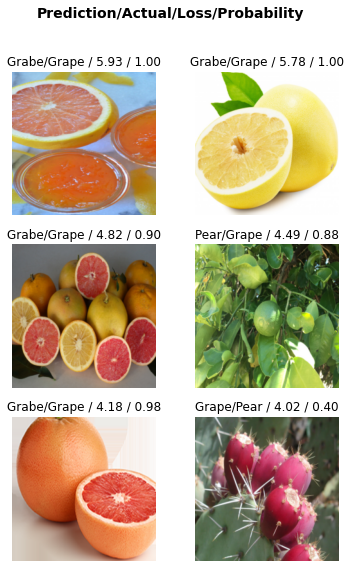

In [114]:
interp.plot_top_losses(6, nrows=3)

In [116]:
cleaner = ImageClassifierCleaner (model)

for idx,fruit in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), str(path/sam).split('.')[0] +"_fixed.jpg")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [117]:
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [118]:
model_inf = load_learner(path/'export.pkl')

In [119]:
model_inf.predict('fruits/Apple/Image_10.jpg')

('Apple', tensor(0), tensor([0.9890, 0.0020, 0.0065, 0.0024]))

In [120]:
model_inf.dls.vocab

['Apple', 'Grabe', 'Grape', 'Pear']

In [121]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='classify')
out_pl = widgets.Output()
lbl =  widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = model_inf.predict(img)
    lbl.value = f' Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [122]:
VBox([widgets.Label('Select fruit'), btn_upload, btn_run, out_pl, lbl])